In [192]:
import torch
import torch.nn as nn

In [193]:
class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()
        
        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.fuse = nn.Sequential(nn.Conv2d(30, 1, 1, padding=0))
    
    def forward(self, img_tensor):
        x1 = self.branch1(img_tensor)
        x2 = self.branch2(img_tensor)
        x3 = self.branch3(img_tensor)
        x = torch.cat((x1, x2, x3), 1)
        x = self.fuse(x)
        x = nn.functional.sigmoid(x)
        return x

In [195]:
img=torch.rand((1,3,256,256),dtype=torch.float) # batchsize=1, RGB=3, 大小为256X256
mcnn=MCNN()
out_dmap=mcnn(img)
print(out_dmap)       # 2个pooling层后应该为原来1/4

tensor([[[[0.5356, 0.5335, 0.5336,  ..., 0.5336, 0.5339, 0.5323],
          [0.5354, 0.5344, 0.5338,  ..., 0.5342, 0.5346, 0.5340],
          [0.5367, 0.5336, 0.5362,  ..., 0.5347, 0.5359, 0.5339],
          ...,
          [0.5366, 0.5343, 0.5353,  ..., 0.5349, 0.5350, 0.5363],
          [0.5373, 0.5364, 0.5370,  ..., 0.5360, 0.5369, 0.5356],
          [0.5369, 0.5353, 0.5374,  ..., 0.5356, 0.5344, 0.5347]]]],
       grad_fn=<SigmoidBackward0>)


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from dataset import CrowdCountingDataset
from model import MCNN

/opt/anaconda3/envs/mymcnn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/mymcnn/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /opt/anaconda3/envs/mymcnn/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /opt/anaconda3/envs/mymcnn/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
model = MCNN()

In [6]:
checkpoint = torch.load('checkpoints/checkpointA.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [29]:
model.eval()

MCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (9): ReLU(inplace=True)
  )
  (branch2): Sequential(
    (0): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [139]:
train_data = CrowdCountingDataset('../shanghaitech/part_A_test.json', transform=transform)
dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

In [8]:
from model import MCNN
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from dataset import CrowdCountingDataset
import os

In [138]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [150]:
data_iter = iter(dataloader)
imgs, densitys = data_iter.__next__()


In [25]:
imgs[0].shape

torch.Size([3, 256, 256])

In [84]:
output = model(imgs)

In [86]:
densitys.shape

torch.Size([16, 64, 64])

In [85]:
output.shape

torch.Size([16, 1, 64, 64])

In [34]:
from matplotlib import cm as CM

In [27]:
import matplotlib.pyplot as plt

预测人数: 58.6145133972168
真实人数: 49.393226623535156


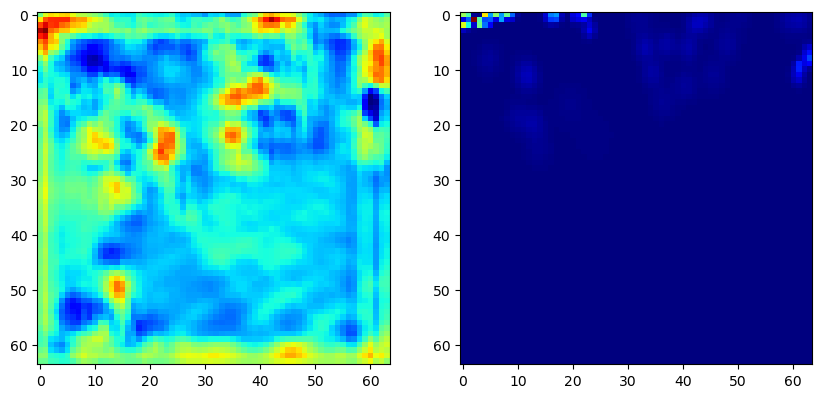

In [169]:
with torch.no_grad():
    output = model(imgs)
    output1 = output[0]
    print(f'预测人数: {torch.sum(output1)}')
    print(f'真实人数: {torch.sum(densitys[0])}')
    # output1 = np.squeeze(output1)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(output1[0], cmap=CM.jet)

    ax[1].imshow(densitys[0].numpy(), cmap=CM.jet)

    plt.show()

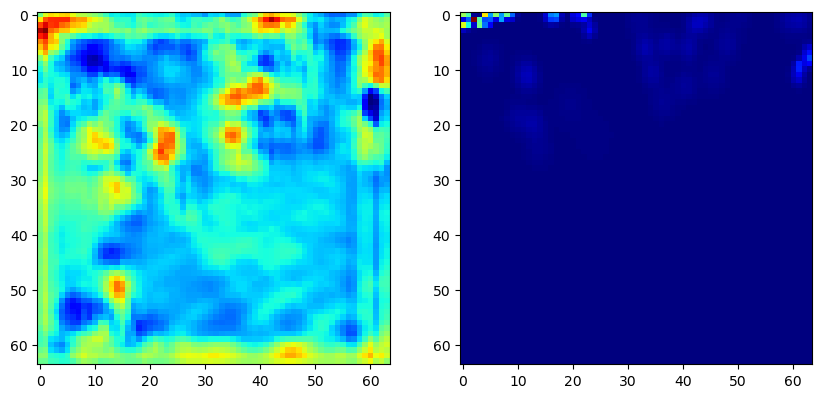

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(output1[0], cmap=CM.jet)

ax[1].imshow(densitys[0].numpy(), cmap=CM.jet)

plt.show()

In [77]:
density_map = torch.randn(1, 64, 64)

In [182]:
output1[0]
min_value = output1[0].min()
max_value = output1[0].max()
normal_out = (output1[0] - min_value) / (max_value - min_value)

In [183]:
min_value = densitys[0].min()
max_value = densitys[0].max()
normal_den = (densitys[0] - min_value) / (max_value - min_value)

In [184]:
normal_out

tensor([[0.4914, 0.6203, 0.6752,  ..., 0.3639, 0.3776, 0.4536],
        [0.6632, 0.8206, 0.8618,  ..., 0.5315, 0.5065, 0.5373],
        [0.8360, 0.9165, 0.8516,  ..., 0.5507, 0.5335, 0.5534],
        ...,
        [0.4727, 0.4940, 0.3472,  ..., 0.5651, 0.5904, 0.5720],
        [0.5130, 0.5194, 0.4056,  ..., 0.6365, 0.6555, 0.6016],
        [0.4786, 0.4735, 0.4221,  ..., 0.5573, 0.5838, 0.5264]])

In [185]:
normal_den


tensor([[5.3736e-01, 4.4657e-01, 2.1047e-02,  ..., 3.7377e-02, 2.9581e-02,
         1.4170e-02],
        [9.1139e-02, 2.1545e-01, 1.0000e+00,  ..., 4.3882e-02, 3.4701e-02,
         1.6618e-02],
        [6.1789e-01, 3.8485e-01, 6.9807e-02,  ..., 3.7186e-02, 2.9013e-02,
         1.3821e-02],
        ...,
        [6.0507e-04, 7.2541e-04, 8.4775e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.5634e-04, 6.6668e-04, 7.7860e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0414e-04, 6.0393e-04, 7.0497e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

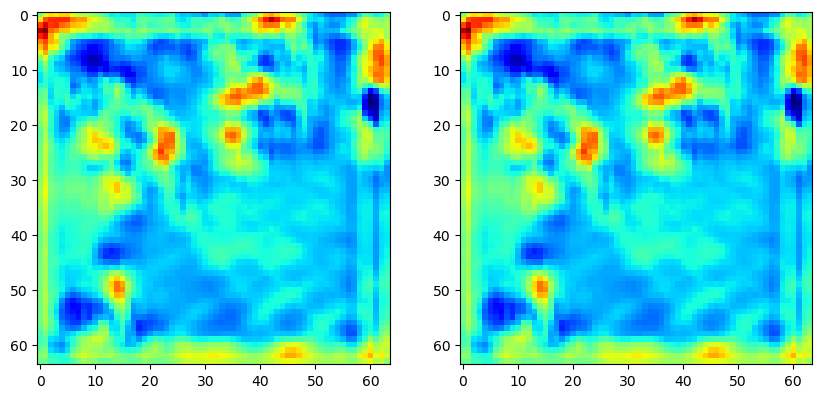

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(normal_out, cmap=CM.jet, vmin=0, vmax=1)

ax[1].imshow(output1[0], cmap=CM.jet)

plt.show()